In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import geopy
from  geopy.geocoders import Nominatim
from bs4 import BeautifulSoup
import requests
import numpy as np
from pandas.io.json import json_normalize
import folium
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

In [2]:
CLIENT_ID = 'CIIK1O20T5RJVSB5WKKYJKDPFU02ZS04QKMA5NC0JU2YGVAW'
CLIENT_SECRET = 'T30D1225NPN05AIPPIQTFO3BBHU03IB5ZMM5OJUBWLLPFCZT'
VERSION = '202011221'
LIMIT = 100
radius = 500

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: CIIK1O20T5RJVSB5WKKYJKDPFU02ZS04QKMA5NC0JU2YGVAW
CLIENT_SECRET:T30D1225NPN05AIPPIQTFO3BBHU03IB5ZMM5OJUBWLLPFCZT


In [3]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [4]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [5]:
ny_data.shape

(306, 4)

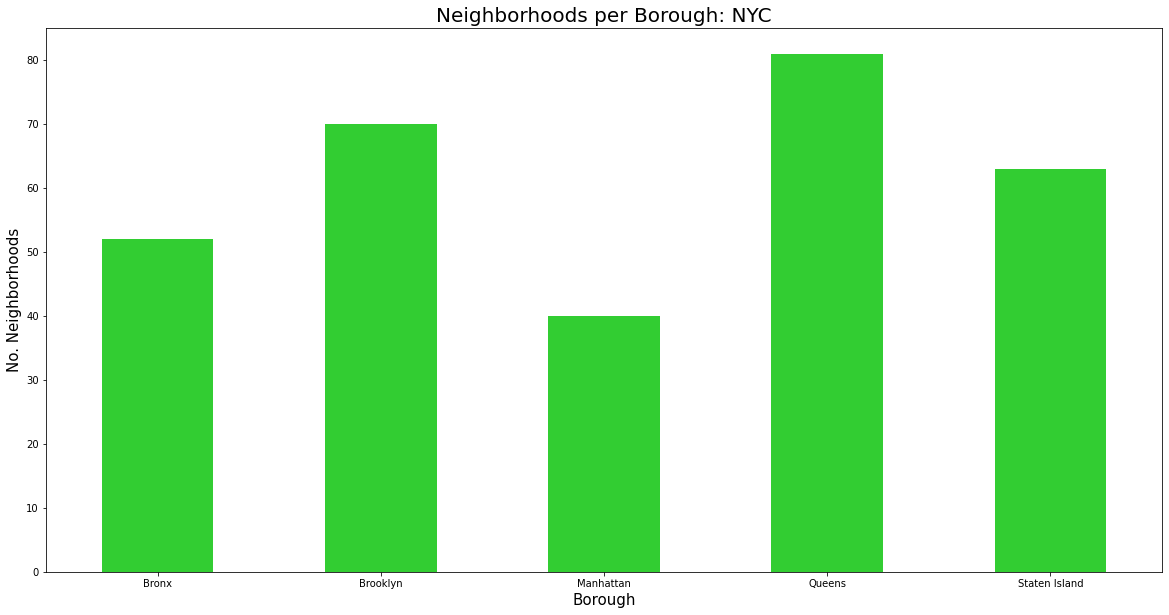

In [6]:
clr = "limegreen"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(20,10), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [7]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
indonesian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indonesian_resturants=venues[venues['Category']=='Indonesian Restaurant']   
    print('(',count,'/',len(ny_data),')','Indonesian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indonesian_resturants)))
    print(row)
    for resturant_detail in indonesian_resturants.values.tolist():
        id, name , category=resturant_detail
        indonesian_rest_ny = indonesian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indonesian Resturants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Indonesian Resturants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Indonesian Resturants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Indonesian Resturants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Indonesian Resturants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Indonesian Resturants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Indonesian Resturants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Indonesian Resturants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Indonesian Resturants in N

In [8]:
indonesian_rest_ny.to_csv('indonesian_rest_ny_tocsv1.csv')

In [9]:
indonesian_rest_ny = pd.read_csv('indonesian_rest_ny_tocsv1.csv')
indonesian_rest_ny.head()

,Unnamed: 0,Borough,Neighborhood,ID,Name
0,0,Queens,Elmhurst,53c99461498e31473d141ea2,Sky Cafe


In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
nyc_venues = getNearbyVenues(names=ny_data['Neighborhood'],
                                   latitudes=ny_data['Latitude'],
                                   longitudes=ny_data['Longitude']
                                  )

In [13]:
nyc_venues.tail(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
10149,Queensbridge,40.756091,-73.945631,Z Hotel New York - Rooftop Bar/Lounge,40.752113,-73.947585,Hotel Bar
10150,Queensbridge,40.756091,-73.945631,SummerStage - Queensbridge Park,40.755514,-73.949125,Performing Arts Venue
10151,Queensbridge,40.756091,-73.945631,Roosevelt Island Running Path,40.754902,-73.948958,Gym / Fitness Center
10152,Queensbridge,40.756091,-73.945631,Queensbridge Basketball Courts,40.755060,-73.949103,Basketball Court
10153,Queensbridge,40.756091,-73.945631,Estate Garden And Grill,40.753700,-73.948841,Beer Garden
10154,Queensbridge,40.756091,-73.945631,Track 114,40.753008,-73.947833,Platform
10155,Fox Hills,40.617311,-74.081740,SUBWAY,40.618939,-74.082881,Sandwich Place
10156,Fox Hills,40.617311,-74.081740,Bums Pancake N Waffle Grill,40.618287,-74.085525,American Restaurant
10157,Fox Hills,40.617311,-74.081740,Targee Milk & Things,40.614410,-74.084455,Grocery Store
10158,Fox Hills,40.617311,-74.081740,MTA Bus - Tompkins Av & Vanderbilt Av (S52/S76...,40.620052,-74.077180,Bus Stop


In [14]:
nyc_venue_rest = nyc_venues[nyc_venues['Venue Category'].str.contains('Restaurant', na=False)].reset_index(drop=True)

nyc_venue_rest.tail(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
2486,Hudson Yards,40.756658,-74.000111,Chirp,40.753377,-73.996116,Peruvian Restaurant
2487,Hudson Yards,40.756658,-74.000111,Tavola,40.755531,-73.994769,Italian Restaurant
2488,Hudson Yards,40.756658,-74.000111,Zoob Zib Thai Noodle Bar,40.754530,-73.995566,Thai Restaurant
2489,Hudson Yards,40.756658,-74.000111,La Barra,40.752849,-74.001750,Tapas Restaurant
2490,Hudson Yards,40.756658,-74.000111,Via Trenta,40.753004,-74.002898,Italian Restaurant
2491,Hudson Yards,40.756658,-74.000111,Spanish Diner,40.752394,-74.001491,Spanish Restaurant
2492,Hudson Yards,40.756658,-74.000111,Treadwell,40.759964,-73.996284,Restaurant
2493,Hammels,40.587338,-73.805530,McDonald's,40.588433,-73.809752,Fast Food Restaurant
2494,Queensbridge,40.756091,-73.945631,Boulevard Restaurant,40.755648,-73.941834,Spanish Restaurant
2495,Fox Hills,40.617311,-74.081740,Bums Pancake N Waffle Grill,40.618287,-74.085525,American Restaurant


In [15]:
# one hot encoding
nyc_onehot = pd.get_dummies(nyc_venue_rest[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nyc_onehot['Neighborhood'] = nyc_venue_rest['Neighborhood'] 

# move neighborhood column to the first column
cols=list(nyc_onehot.columns.values)
cols.pop(cols.index('Neighborhood'))
nyc_onehot=nyc_onehot[['Neighborhood']+cols]

# rename Neighborhood for Neighbourhood so that future merge works
nyc_onehot.rename(columns = {'Neighborhood': 'Neighbourhood'}, inplace = True)

nyc_onehot.tail(10)

,Neighbourhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Brazilian Restaurant,Burmese Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Polish Restaurant,Puerto Rican Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Soba Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
2486,Hudson Yards,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2487,Hudson Yards,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2488,Hudson Yards,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2489,Hudson Yards,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2490,Hudson Yards,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2491,Hudson Yards,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2492,Hudson Yards,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2493,Hammels,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2494,Queensbridge,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2495,Fox Hills,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
nyc_grouped = nyc_onehot.groupby('Neighbourhood').mean().reset_index()

nyc_grouped

,Neighbourhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Brazilian Restaurant,Burmese Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Polish Restaurant,Puerto Rican Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Soba Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
0,Allerton,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Annadale,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Arlington,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

In [17]:
num_top_venues = 5

for hood in nyc_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = nyc_grouped[nyc_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allerton----
                  venue  freq
0    Chinese Restaurant  0.50
1  Fast Food Restaurant  0.25
2    Spanish Restaurant  0.25
3  Pakistani Restaurant  0.00
4    Russian Restaurant  0.00


----Annadale----
                venue  freq
0          Restaurant   1.0
1   Afghan Restaurant   0.0
2  African Restaurant   0.0
3  Russian Restaurant   0.0
4    Ramen Restaurant   0.0


----Arlington----
                 venue  freq
0  American Restaurant   1.0
1    Afghan Restaurant   0.0
2    Paella Restaurant   0.0
3   Russian Restaurant   0.0
4           Restaurant   0.0


----Arrochar----
                       venue  freq
0         Italian Restaurant   0.4
1   Mediterranean Restaurant   0.2
2  Middle Eastern Restaurant   0.2
3          Polish Restaurant   0.2
4          Afghan Restaurant   0.0


----Arverne----
                     venue  freq
0               Restaurant   0.5
1          Thai Restaurant   0.5
2        Afghan Restaurant   0.0
3  North Indian Restaurant   0.0
4         

In [18]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [19]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = nyc_grouped['Neighbourhood']

for ind in np.arange(nyc_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nyc_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Chinese Restaurant,Fast Food Restaurant,Spanish Restaurant,Vietnamese Restaurant,Greek Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
1,Annadale,Restaurant,Vietnamese Restaurant,Kebab Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant
2,Arlington,American Restaurant,Vietnamese Restaurant,Hawaiian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant
3,Arrochar,Italian Restaurant,Polish Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,Vietnamese Restaurant,Greek Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant
4,Arverne,Restaurant,Thai Restaurant,Halal Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
5,Astoria,Middle Eastern Restaurant,Seafood Restaurant,Indian Restaurant,Greek Restaurant,Mediterranean Restaurant,Italian Restaurant,Japanese Restaurant,Chinese Restaurant,Latin American Restaurant,Mexican Restaurant
6,Astoria Heights,Italian Restaurant,Vietnamese Restaurant,Halal Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant
7,Auburndale,Italian Restaurant,American Restaurant,Fast Food Restaurant,Sushi Restaurant,Vietnamese Restaurant,Halal Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant
8,Bath Beach,Chinese Restaurant,Italian Restaurant,Fast Food Restaurant,Peruvian Restaurant,Cantonese Restaurant,Sushi Restaurant,Kebab Restaurant,Middle Eastern Restaurant,German Restaurant,Restaurant
9,Battery Park City,Japanese Restaurant,Italian Restaurant,Mediterranean Restaurant,Mexican Restaurant,Chinese Restaurant,Sushi Restaurant,Greek Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant


In [20]:
kclusters = 5

nyc_grouped_clustering = nyc_grouped.drop('Neighbourhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_grouped_clustering)

kmeans.labels_[0:10]

array([0, 2, 4, 4, 2, 2, 4, 4, 0, 2])

In [23]:
nyc_merged = ny_data

neighborhoods_venues_sorted.rename(columns={'Neighbourhood':'Neighborhood'}, inplace=True)

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

neighborhoods_venues_sorted['Cluster Labels'] = neighborhoods_venues_sorted['Cluster Labels'].astype(int)

nyc_merged = nyc_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

nyc_merged.head(20)

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Wakefield,40.894705,-73.847201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Bronx,Co-op City,40.874294,-73.829939,3.0,Fast Food Restaurant,Restaurant,Vietnamese Restaurant,Kebab Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant
2,Bronx,Eastchester,40.887556,-73.827806,1.0,Caribbean Restaurant,Seafood Restaurant,Fast Food Restaurant,Chinese Restaurant,Vietnamese Restaurant,Greek Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
3,Bronx,Fieldston,40.895437,-73.905643,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Bronx,Riverdale,40.890834,-73.912585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Bronx,Kingsbridge,40.881687,-73.902818,2.0,Latin American Restaurant,Mexican Restaurant,Spanish Restaurant,Fast Food Restaurant,Seafood Restaurant,Chinese Restaurant,Caribbean Restaurant,Vietnamese Restaurant,Falafel Restaurant,Filipino Restaurant
6,Manhattan,Marble Hill,40.876551,-73.910660,2.0,Seafood Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant
7,Bronx,Woodlawn,40.898273,-73.867315,4.0,Italian Restaurant,Indian Restaurant,Vietnamese Restaurant,Halal Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
8,Bronx,Norwood,40.877224,-73.879391,0.0,Chinese Restaurant,Restaurant,Spanish Restaurant,American Restaurant,Fast Food Restaurant,Mexican Restaurant,Caribbean Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant
9,Bronx,Williamsbridge,40.881039,-73.857446,1.0,Caribbean Restaurant,Vietnamese Restaurant,Empanada Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant


In [36]:
nyc_merged = nyc_merged.dropna().reset_index()

nyc_merged.head()

,index,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Bronx,Co-op City,40.874294,-73.829939,3,Fast Food Restaurant,Restaurant,Vietnamese Restaurant,Kebab Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant
1,2,Bronx,Eastchester,40.887556,-73.827806,1,Caribbean Restaurant,Seafood Restaurant,Fast Food Restaurant,Chinese Restaurant,Vietnamese Restaurant,Greek Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
2,5,Bronx,Kingsbridge,40.881687,-73.902818,2,Latin American Restaurant,Mexican Restaurant,Spanish Restaurant,Fast Food Restaurant,Seafood Restaurant,Chinese Restaurant,Caribbean Restaurant,Vietnamese Restaurant,Falafel Restaurant,Filipino Restaurant
3,6,Manhattan,Marble Hill,40.876551,-73.910660,2,Seafood Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant
4,7,Bronx,Woodlawn,40.898273,-73.867315,4,Italian Restaurant,Indian Restaurant,Vietnamese Restaurant,Halal Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant


In [37]:
nyc_merged['Cluster Labels'] = nyc_merged['Cluster Labels'].astype(int)

nyc_merged.tail(10)

,index,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
259,295,Brooklyn,Highland Park,40.681999,-73.890346,2,Latin American Restaurant,Spanish Restaurant,Vietnamese Restaurant,Halal Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
260,296,Brooklyn,Madison,40.609378,-73.948415,4,Restaurant,Italian Restaurant,Vietnamese Restaurant,Greek Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
261,297,Bronx,Bronxdale,40.852723,-73.861726,2,Eastern European Restaurant,Italian Restaurant,Mexican Restaurant,Chinese Restaurant,Spanish Restaurant,Greek Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant
262,298,Bronx,Allerton,40.865788,-73.859319,0,Chinese Restaurant,Fast Food Restaurant,Spanish Restaurant,Vietnamese Restaurant,Greek Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
263,299,Bronx,Kingsbridge Heights,40.870392,-73.901523,2,Mexican Restaurant,Vietnamese Restaurant,Latin American Restaurant,Chinese Restaurant,Spanish Restaurant,Greek Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant
264,300,Brooklyn,Erasmus,40.646926,-73.948177,1,Caribbean Restaurant,Vietnamese Restaurant,Empanada Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant
265,301,Manhattan,Hudson Yards,40.756658,-74.000111,4,American Restaurant,Italian Restaurant,Peruvian Restaurant,Thai Restaurant,Spanish Restaurant,Asian Restaurant,Tapas Restaurant,Restaurant,Kebab Restaurant,Greek Restaurant
266,302,Queens,Hammels,40.587338,-73.805530,3,Fast Food Restaurant,Vietnamese Restaurant,Venezuelan Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant
267,304,Queens,Queensbridge,40.756091,-73.945631,2,Spanish Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant
268,305,Staten Island,Fox Hills,40.617311,-74.081740,4,American Restaurant,Vietnamese Restaurant,Hawaiian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant


In [29]:
latitude = 40.1728
longitude = -74.0060

map_clusters_nyc = folium.Map(location=[latitude, longitude], zoom_start=12)

x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(nyc_merged['Latitude'], nyc_merged['Longitude'], nyc_merged['Neighborhood'], nyc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_nyc)
       
map_clusters_nyc

In [38]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 0, nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Bronx,0,Chinese Restaurant,Restaurant,Spanish Restaurant,American Restaurant,Fast Food Restaurant,Mexican Restaurant,Caribbean Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant
10,Bronx,0,Chinese Restaurant,Mexican Restaurant,Italian Restaurant,Spanish Restaurant,Vietnamese Restaurant,Greek Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant
11,Bronx,0,Chinese Restaurant,African Restaurant,American Restaurant,Latin American Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Hawaiian Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
14,Bronx,0,Restaurant,Puerto Rican Restaurant,Chinese Restaurant,Greek Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
15,Bronx,0,Latin American Restaurant,Cuban Restaurant,Chinese Restaurant,Vietnamese Restaurant,Halal Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
16,Bronx,0,Chinese Restaurant,Seafood Restaurant,Spanish Restaurant,Latin American Restaurant,Italian Restaurant,Asian Restaurant,Vietnamese Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant
23,Bronx,0,Chinese Restaurant,Latin American Restaurant,Vietnamese Restaurant,Halal Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant
26,Bronx,0,Chinese Restaurant,Restaurant,American Restaurant,Italian Restaurant,Asian Restaurant,Mexican Restaurant,Caribbean Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant
38,Bronx,0,Italian Restaurant,Chinese Restaurant,Caribbean Restaurant,Latin American Restaurant,Fast Food Restaurant,Spanish Restaurant,Vietnamese Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant
50,Brooklyn,0,Chinese Restaurant,Fast Food Restaurant,Caribbean Restaurant,Vietnamese Restaurant,Halal Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant


In [39]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 1, nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Bronx,1,Caribbean Restaurant,Seafood Restaurant,Fast Food Restaurant,Chinese Restaurant,Vietnamese Restaurant,Greek Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
6,Bronx,1,Caribbean Restaurant,Vietnamese Restaurant,Empanada Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant
36,Bronx,1,Caribbean Restaurant,Vietnamese Restaurant,Empanada Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant
69,Brooklyn,1,Caribbean Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Empanada Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant
70,Brooklyn,1,Caribbean Restaurant,Vietnamese Restaurant,Empanada Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant
151,Queens,1,Vegetarian / Vegan Restaurant,Caribbean Restaurant,Vietnamese Restaurant,Halal Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
152,Queens,1,Caribbean Restaurant,Seafood Restaurant,Fast Food Restaurant,Chinese Restaurant,Southern / Soul Food Restaurant,Vietnamese Restaurant,Empanada Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant
155,Queens,1,Caribbean Restaurant,Restaurant,Chinese Restaurant,Greek Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
171,Queens,1,Caribbean Restaurant,Vietnamese Restaurant,Empanada Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant
224,Brooklyn,1,Caribbean Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Empanada Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant


In [40]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 2, nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Bronx,2,Latin American Restaurant,Mexican Restaurant,Spanish Restaurant,Fast Food Restaurant,Seafood Restaurant,Chinese Restaurant,Caribbean Restaurant,Vietnamese Restaurant,Falafel Restaurant,Filipino Restaurant
3,Manhattan,2,Seafood Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant
7,Bronx,2,Fast Food Restaurant,Mexican Restaurant,Spanish Restaurant,Vietnamese Restaurant,Halal Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
9,Bronx,2,Seafood Restaurant,American Restaurant,Italian Restaurant,French Restaurant,Spanish Restaurant,Vietnamese Restaurant,Greek Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant
12,Bronx,2,Spanish Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant
13,Bronx,2,Fast Food Restaurant,Spanish Restaurant,Latin American Restaurant,Chinese Restaurant,Restaurant,African Restaurant,American Restaurant,Greek Restaurant,Caribbean Restaurant,Halal Restaurant
17,Bronx,2,Mexican Restaurant,Vietnamese Restaurant,Halal Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant
18,Bronx,2,Spanish Restaurant,Latin American Restaurant,Peruvian Restaurant,Chinese Restaurant,Vietnamese Restaurant,Greek Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant
19,Bronx,2,Latin American Restaurant,Peruvian Restaurant,Spanish Restaurant,Restaurant,Vietnamese Restaurant,Gluten-free Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant
21,Bronx,2,Seafood Restaurant,Spanish Restaurant,Vietnamese Restaurant,Greek Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant


In [41]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 3, nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,3,Fast Food Restaurant,Restaurant,Vietnamese Restaurant,Kebab Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant
20,Bronx,3,Latin American Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Halal Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant
136,Queens,3,Fast Food Restaurant,Vietnamese Restaurant,Venezuelan Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant
197,Brooklyn,3,Fast Food Restaurant,African Restaurant,Vietnamese Restaurant,Hawaiian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant
210,Staten Island,3,Fast Food Restaurant,Vietnamese Restaurant,Venezuelan Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant
253,Queens,3,Fast Food Restaurant,Vietnamese Restaurant,Venezuelan Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant
258,Staten Island,3,Fast Food Restaurant,Mexican Restaurant,Vietnamese Restaurant,Halal Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant
266,Queens,3,Fast Food Restaurant,Vietnamese Restaurant,Venezuelan Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant


In [42]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 4, nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Bronx,4,Italian Restaurant,Indian Restaurant,Vietnamese Restaurant,Halal Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
8,Bronx,4,Italian Restaurant,Sushi Restaurant,Chinese Restaurant,Vietnamese Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
25,Bronx,4,American Restaurant,Asian Restaurant,Italian Restaurant,Chinese Restaurant,Vietnamese Restaurant,Hawaiian Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
30,Bronx,4,Italian Restaurant,Mexican Restaurant,Spanish Restaurant,Restaurant,Japanese Restaurant,Fast Food Restaurant,Eastern European Restaurant,American Restaurant,Indian Restaurant,German Restaurant
32,Bronx,4,Italian Restaurant,Chinese Restaurant,Sushi Restaurant,American Restaurant,Mexican Restaurant,Halal Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant
35,Bronx,4,Italian Restaurant,American Restaurant,Japanese Restaurant,Fast Food Restaurant,Asian Restaurant,Vietnamese Restaurant,Halal Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant
37,Bronx,4,American Restaurant,Italian Restaurant,Spanish Restaurant,Vietnamese Restaurant,Greek Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant
41,Brooklyn,4,Sushi Restaurant,Italian Restaurant,Chinese Restaurant,American Restaurant,Shabu-Shabu Restaurant,Hotpot Restaurant,Greek Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant
44,Brooklyn,4,Italian Restaurant,Vietnamese Restaurant,Halal Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant
57,Brooklyn,4,New American Restaurant,Japanese Restaurant,Italian Restaurant,Halal Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
